# Importing Libraries

In [40]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns 
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from scipy.stats import boxcox
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score ,precision_score , f1_score, confusion_matrix ,accuracy_score ,roc_curve
from sklearn.model_selection import train_test_split ,cross_val_score,GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import mlflow 
import mlflow.sklearn
from sklearn.metrics import auc
import shap 
shap.initjs()
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("/Users/talya/DataSets/Churn_Modelling.csv")

# Explore Data Set

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [4]:
df.shape

(10002, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.describe(include=object)

,Surname,Geography,Gender
count,10002,10001,10002
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5458


In [8]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10002.000000,1.000200e+04,10002.000000,10001.000000,10002.000000,10002.000000,10002.000000,10001.000000,10001.000000,10002.000000,10002.000000
mean,5001.499600,1.569093e+07,650.555089,38.922311,5.012498,76491.112875,1.530194,0.705529,0.514949,100083.331145,0.203759
std,2887.472338,7.193177e+04,96.661615,10.487200,2.891973,62393.474144,0.581639,0.455827,0.499801,57508.117802,0.402812
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2501.250000,1.562852e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50983.750000,0.000000
50%,5001.500000,1.569073e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100185.240000,0.000000
75%,7501.750000,1.575323e+07,718.000000,44.000000,7.000000,127647.840000,2.000000,1.000000,1.000000,149383.652500,0.000000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# First Data Preprocessing

In [9]:
df.drop(["RowNumber","CustomerId"],axis=1,inplace=True) 

In [10]:
df.drop("Surname",axis=1,inplace=True)

# EDA (Univariate Analysis -  Categorical Features )

In [11]:
df_analysis = df.copy()
df_analysis[["HasCrCard", "IsActiveMember" , "Exited","NumOfProducts","Tenure"]] = \
df_analysis[["HasCrCard", "IsActiveMember" , "Exited","NumOfProducts","Tenure"]].astype(object)

In [12]:
cat_feats = [col for col in df_analysis if df_analysis[col].dtype == "object"]
num_feats = [col for col in df_analysis if df_analysis[col].dtype != "object"]
print("Number of Cat Featurs = ", len(cat_feats))
print("Number of Num Featurs = ", len(num_feats))

Number of Cat Featurs =  7
Number of Num Featurs =  4


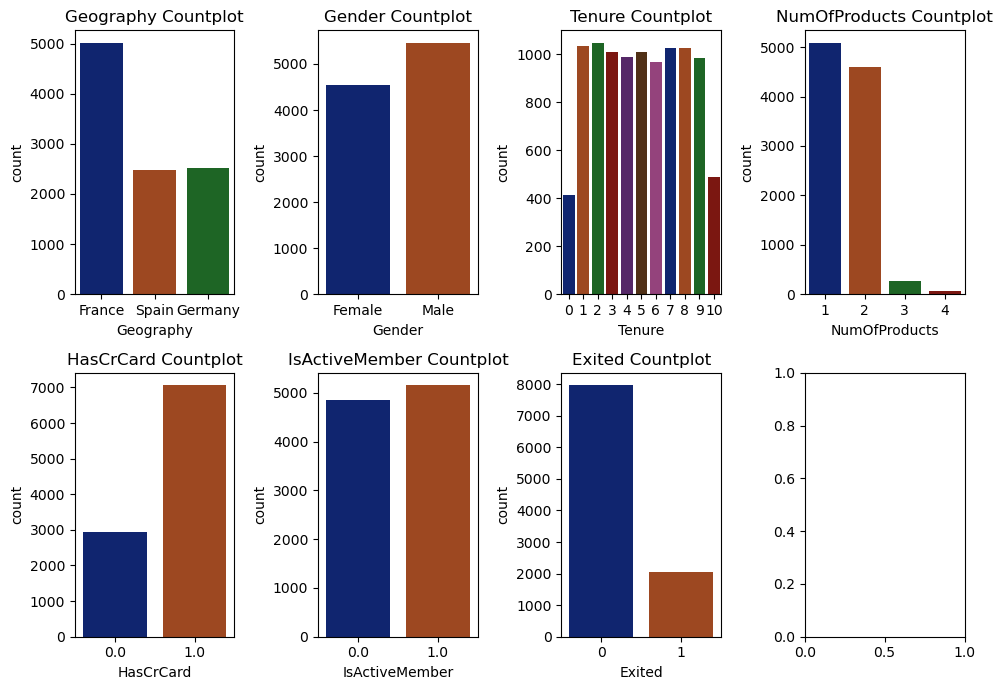

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
axes = axes.flatten()
custom_palette = sns.color_palette("dark", len(cat_feats))
for i, col in enumerate(cat_feats):
    sns.countplot(data=df_analysis , x= col, ax=axes[i],palette=custom_palette)
    axes[i].set_title(f"{col} Countplot")

plt.tight_layout()
plt.show()

# EDA (Univariate Analysis -  Numerical Features )

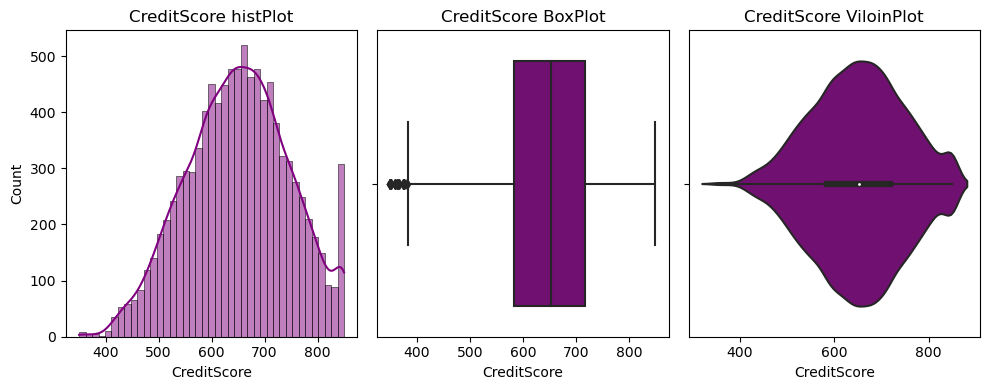

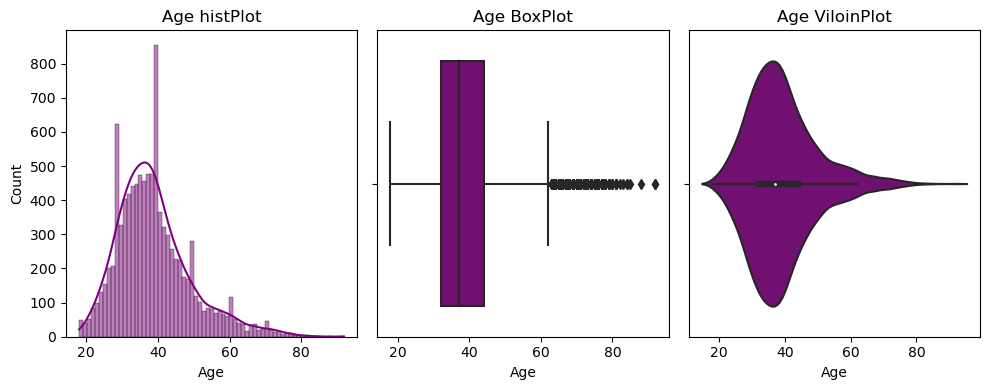

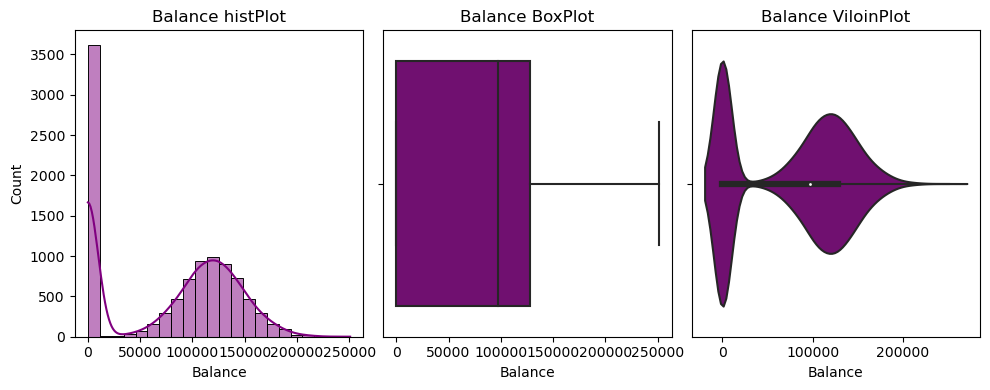

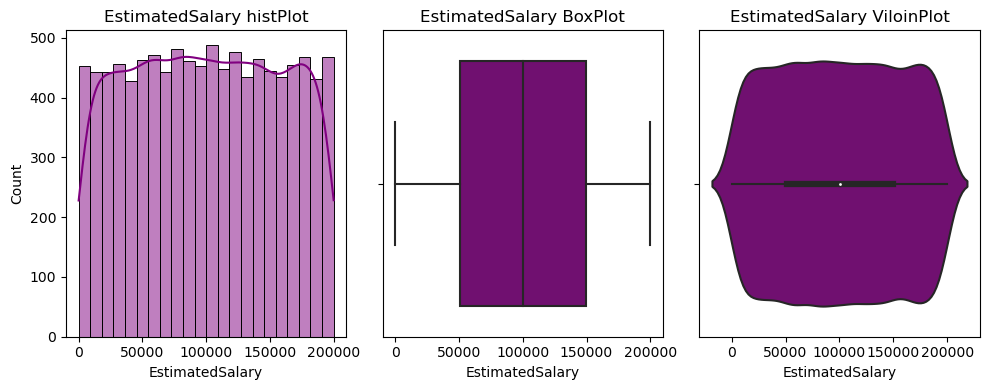

In [14]:
for col in (num_feats):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    axes = axes.flatten()
    sns.histplot(data=df_analysis , x= col, ax=axes[0],kde=True ,color="purple")
    axes[0].set_title(f"{col} histPlot")
    sns.boxplot(data=df_analysis , x= col, ax=axes[1],color="purple")
    axes[1].set_title(f"{col} BoxPlot")
    sns.violinplot(data=df_analysis , x= col, ax=axes[2],color="purple")
    axes[2].set_title(f"{col} ViloinPlot")
    plt.tight_layout()
    plt.show()

In [15]:
kurt = []
skew = []
for col in (num_feats):
    kurt.append(df[col].kurtosis())
    skew.append(df[col].skew())
pd.DataFrame({"Feature":num_feats,"Kurtosis":kurt,"Skewness":skew})

,Feature,Kurtosis,Skewness
0,CreditScore,-0.426340,-0.071878
1,Age,1.395677,1.011292
2,Balance,-1.489231,-0.141295
3,EstimatedSalary,-1.181446,0.002321


# EDA (Bivariate Analysis -  Catogrical Features )

In [16]:
df_analysis["Exited"] = df_analysis["Exited"].astype("float")
for col in cat_feats :
    print(df.groupby(df_analysis[col])["Exited"].mean())

Geography
France     0.161548
Germany    0.324701
Spain      0.166734
Name: Exited, dtype: float64
Gender
Female    0.250660
Male      0.164712
Name: Exited, dtype: float64
Tenure
0     0.230024
1     0.224155
2     0.191794
3     0.211881
4     0.205051
5     0.206522
6     0.202689
7     0.172179
8     0.192195
9     0.216463
10    0.206122
Name: Exited, dtype: float64
NumOfProducts
1    0.277089
2    0.076018
3    0.827068
4    1.000000
Name: Exited, dtype: float64
HasCrCard
0.0    0.208149
1.0    0.201956
Name: Exited, dtype: float64
IsActiveMember
0.0    0.268604
1.0    0.142718
Name: Exited, dtype: float64
Exited
0.0    0.0
1.0    1.0
Name: Exited, dtype: float64


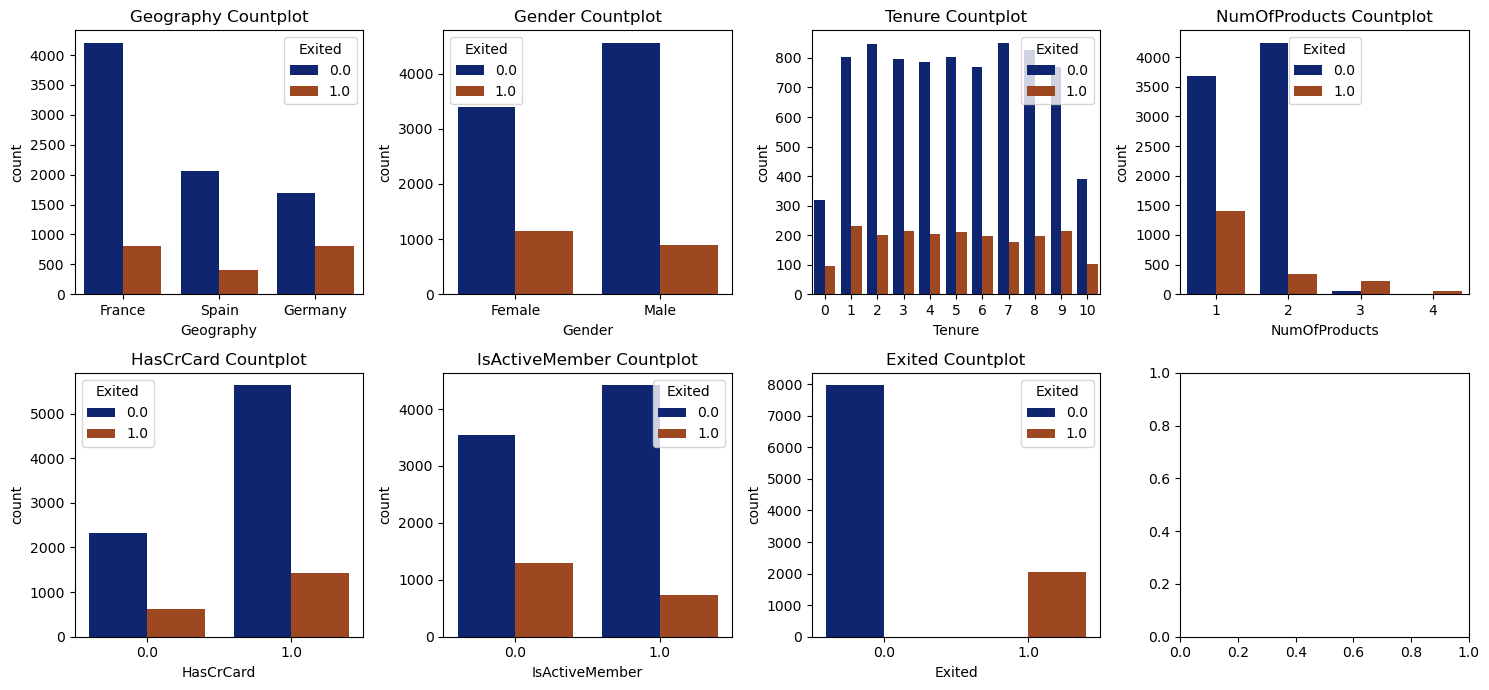

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
axes = axes.flatten()
custom_palette = sns.color_palette("dark", len(cat_feats))
for i, col in enumerate(cat_feats):
    sns.countplot(data=df_analysis , x= col, hue="Exited", ax=axes[i],palette=custom_palette)
    axes[i].set_title(f"{col} Countplot")

plt.tight_layout()
plt.show()

# EDA (Bivariate Analysis -  Numerical Features )


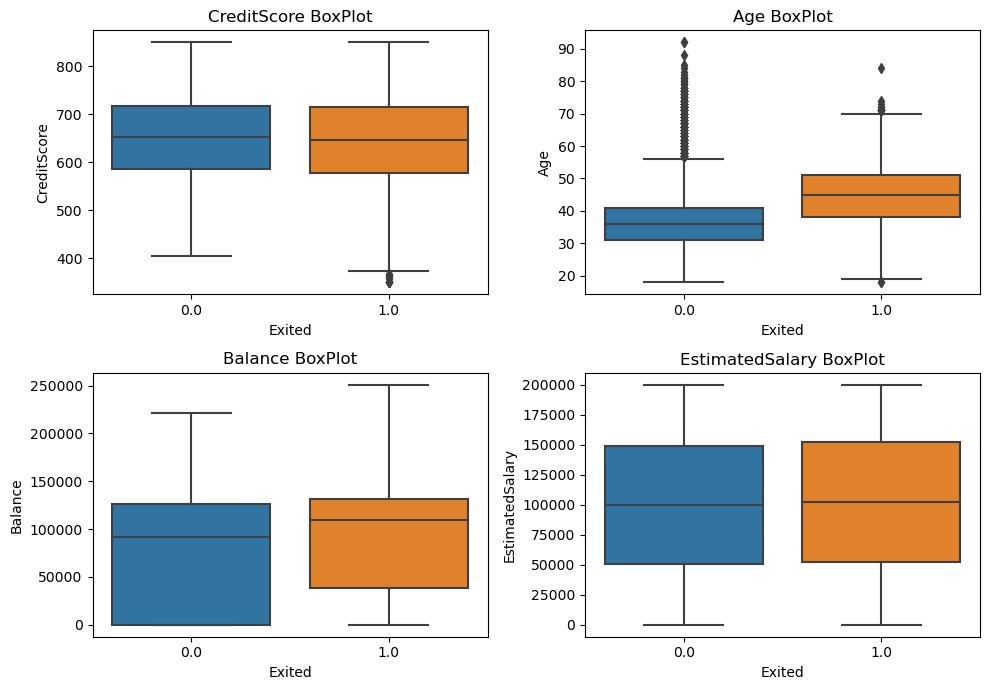

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
axes = axes.flatten()
for i, col in enumerate(num_feats):
    sns.boxplot(data=df_analysis , y= col, x="Exited", ax=axes[i])
    axes[i].set_title(f"{col} BoxPlot")

plt.tight_layout()
plt.show()

# Checking for multicolinearity 

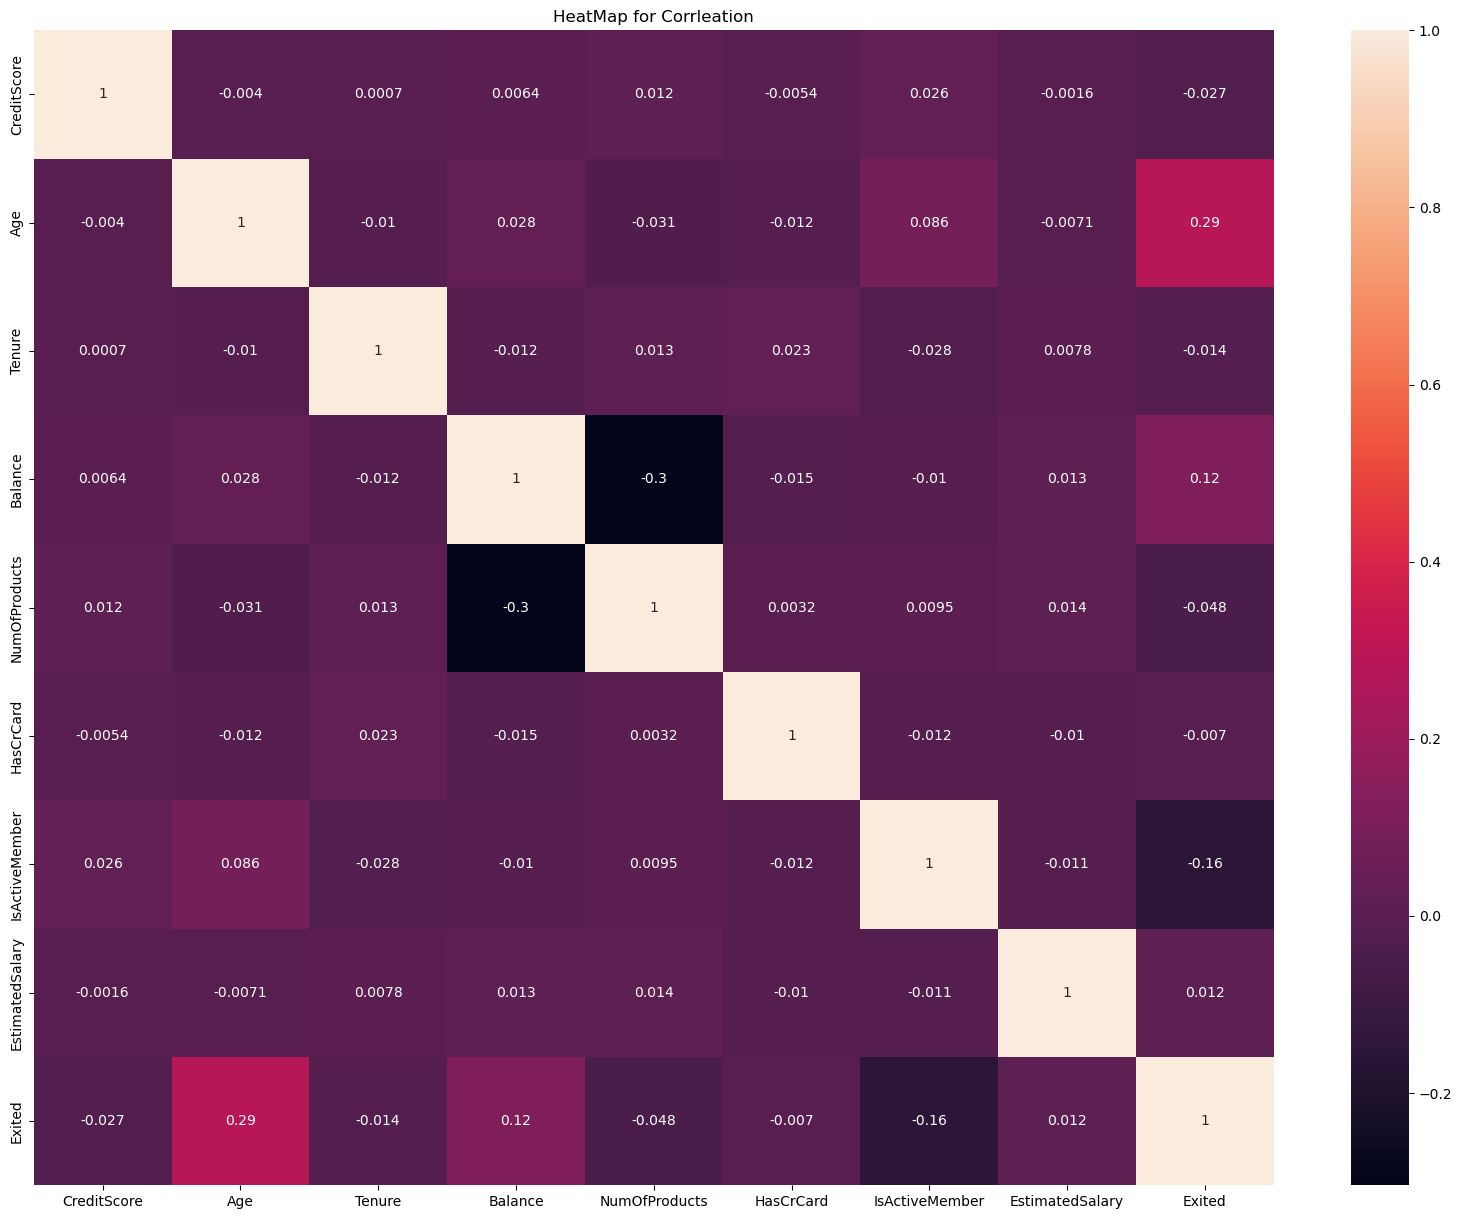

In [19]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True)
plt.title("HeatMap for Corrleation")
plt.show()

# Final Data Preprocessing

# Handling Null Values 

In [20]:
df.dropna(inplace=True)

# Handling Noisy Data 

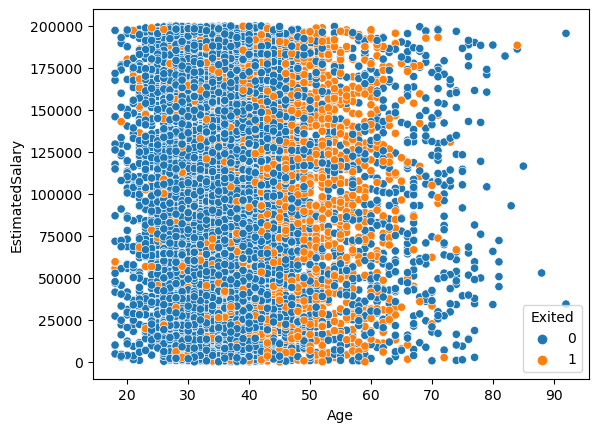

In [21]:
sns.scatterplot(x=df["Age"],y=df["EstimatedSalary"],hue=df["Exited"])
plt.show()

In [22]:
df = df[df["Age"]<85]
boxcox_age, _ = boxcox(df["Age"])  
df.loc[:, "Age"] = boxcox_age

In [23]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,2.571514,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,2.560671,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,2.571514,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,2.537987,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,2.592289,8,113755.78,2,1.0,0.0,149756.71,1


In [24]:
df=df[df["EstimatedSalary"]>16800]

# Preparation Of Ml Modles

In [25]:
one_hot_encoded = pd.get_dummies(df[["Geography","Gender"]],drop_first=True)

df_encoded = pd.concat([df, one_hot_encoded], axis=1)

df_encoded.drop(["Geography","Gender"],axis=1,inplace=True)

In [26]:
df_encoded.shape

(9159, 12)

In [27]:
X = df_encoded.drop("Exited",axis=1)
y = df_encoded["Exited"]

ros = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Implementation Of Ml Models

In [28]:
mlflow.set_tracking_uri("file:///Users/talya/Projects/mlruns")
exp_id = mlflow.set_experiment("Bank Churn Prediction")

In [36]:
def experiment(model, model_name, X_train, X_test, y_train, y_test):
    with mlflow.start_run():
        model_roc = ["rf", "dt", "log"]
        model_shap = ["rf","dt"]
        
        if model_name == "knn":
            knn_params = {
                "n_neighbors": list(range(1, 20)),
                "metric": ["euclidean", "manhattan"]
            }
            
            grid_search = GridSearchCV(model, knn_params, cv=5, scoring='recall', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            
            mlflow.log_params(grid_search.best_params_)
            
            model = grid_search.best_estimator_
            
        elif model_name == "dt":
            dt_param = {
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            grid_search = GridSearchCV(model, dt_param, cv=5, scoring='recall', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            
            mlflow.log_params(grid_search.best_params_)
            
            model = grid_search.best_estimator_
            
        elif model_name == "rf": 
            
            model = model

        
        mlflow.sklearn.log_model(model, model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mlflow.log_metric("cross_accuracy", cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean())
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("Precision", precision_score(y_test, y_pred))
        mlflow.log_metric("Recall", recall_score(y_test, y_pred))
        mlflow.log_metric("f1-score", f1_score(y_test, y_pred))

        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png", artifact_path="confusion_matrix")
        

        
        if model_name in model_roc:
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.tight_layout()
            plt.savefig(f"{model_name}_roc_curve.png")
            mlflow.log_artifact(f"{model_name}_roc_curve.png", artifact_path=f"{model_name}_roc_curve")
            
            
        if model_name in model_shap :
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test)
            shap_values_2d = shap_values[:, :, 0]
            plt.figure(figsize=(10, 10))
            shap.plots.beeswarm(shap_values_2d, show=False,clustering=False)
            plt.tight_layout()
            plt.savefig(f"{model_name}_shap_beeswarm_plot.png")
            mlflow.log_artifact(f"{model_name}_shap_beeswarm_plot.png", artifact_path=f"{model_name}_shap_beeswarm_plot")


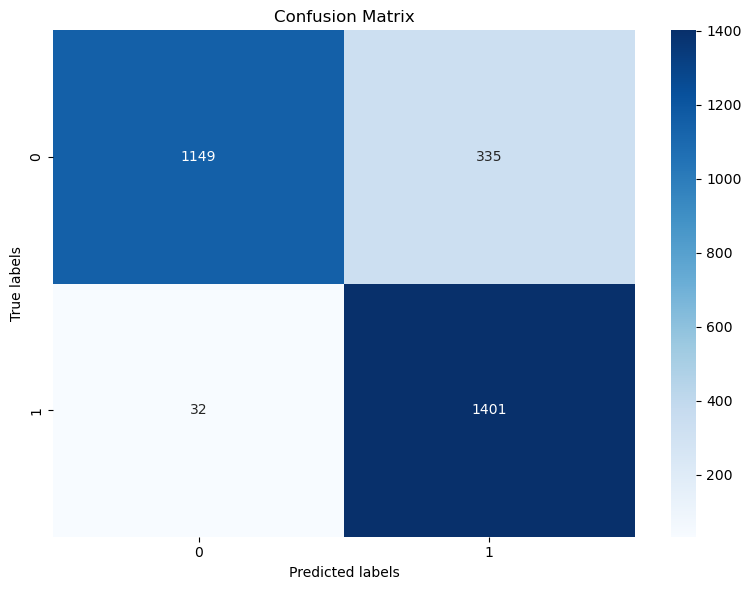

In [37]:
knn = KNeighborsClassifier()
experiment(knn,"knn",X_train, X_test, y_train, y_test)

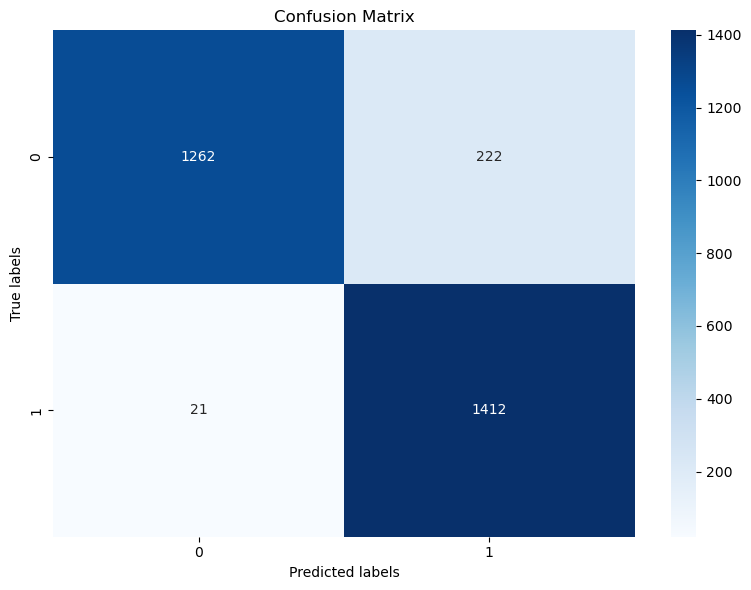

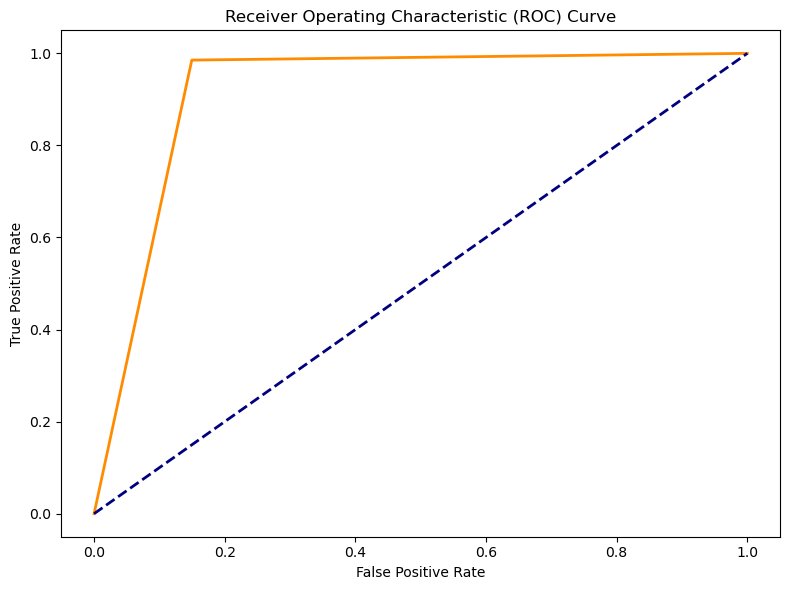

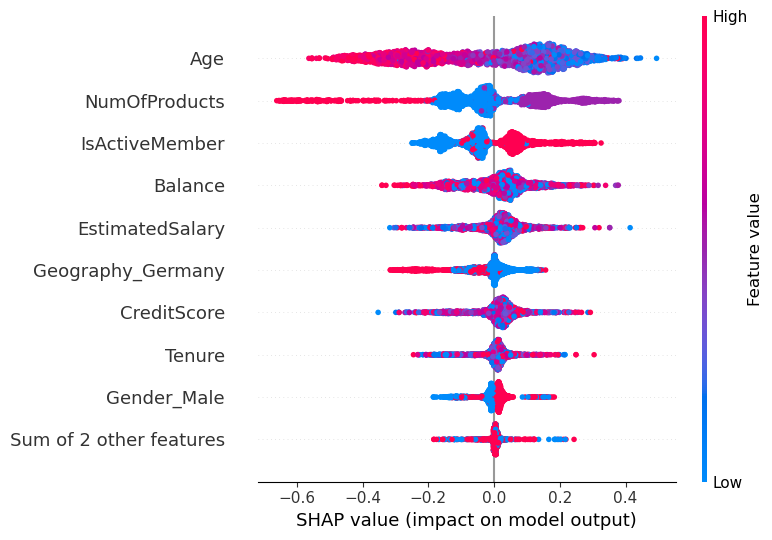

In [38]:
dt = DecisionTreeClassifier()
experiment(dt,"dt",X_train, X_test, y_train, y_test)

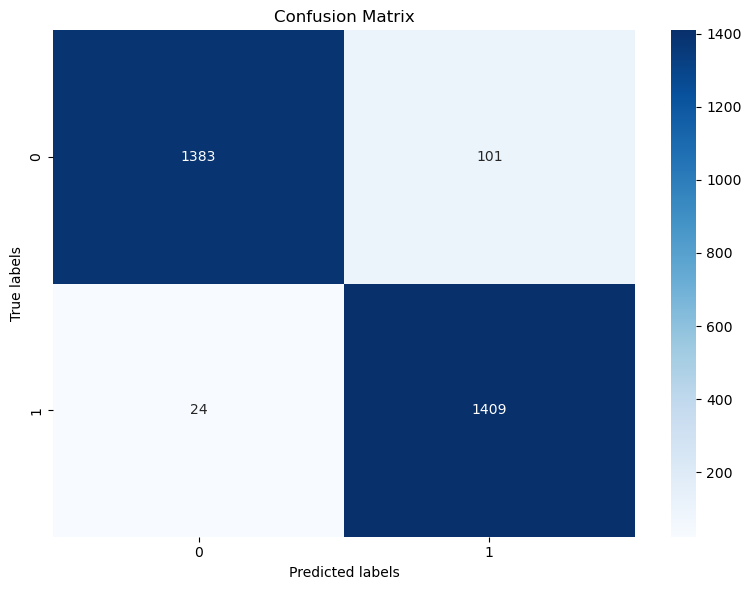

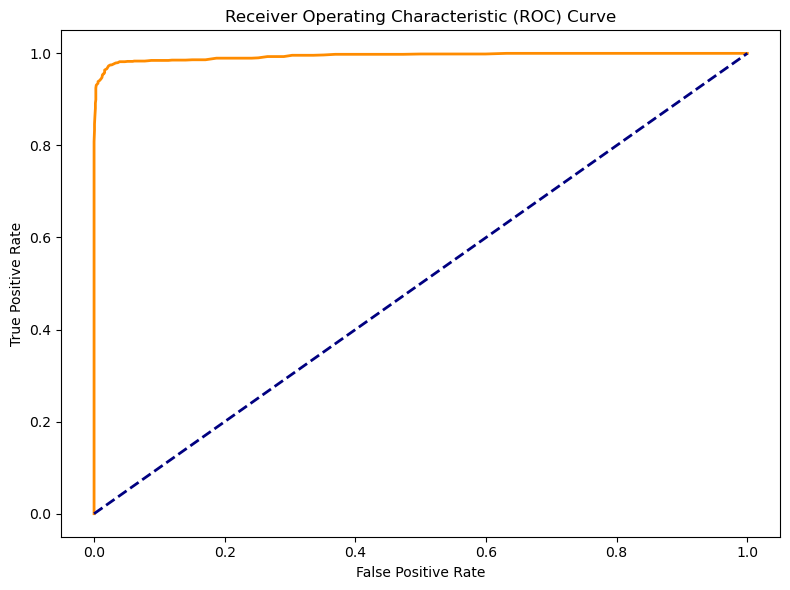

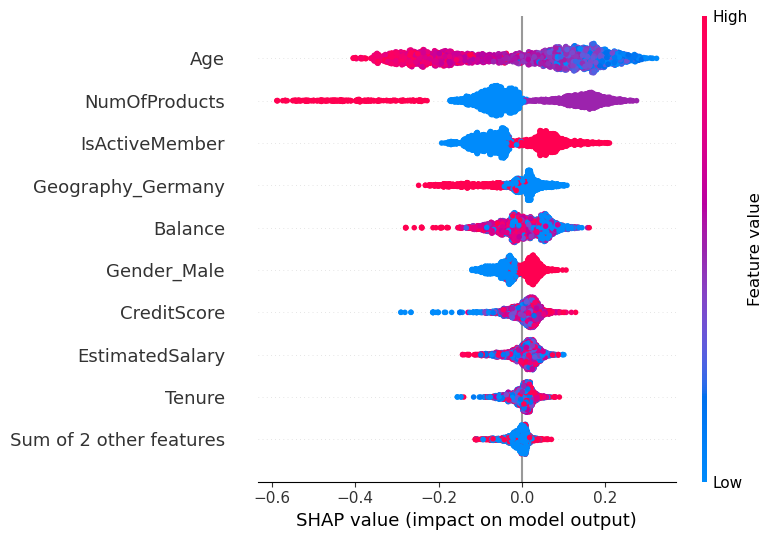

In [39]:
rf = RandomForestClassifier()
experiment(rf,"rf",X_train, X_test, y_train, y_test)